In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')

In [3]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
df_sun = pd.read_csv('Sunspots.csv')
print(df_sun.shape)
df_sun.head()


(3265, 3)


,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


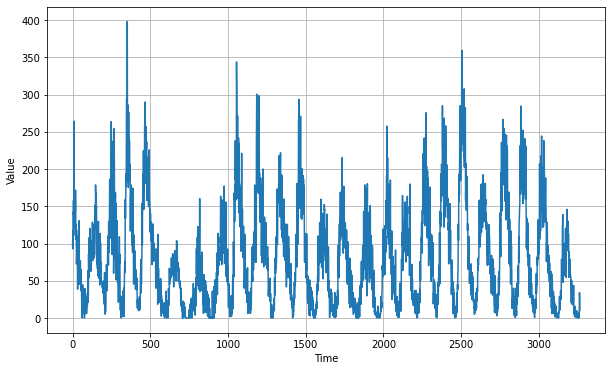

In [13]:
series = df_sun['Monthly Mean Total Sunspot Number']
time = df_sun['Unnamed: 0']

plt.figure(figsize=(10, 6))
plot_series(time, series)

# Split Train-Test Dataset 

In [14]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


# Model 

In [17]:

tf.keras.backend.clear_session()

shuffle_buffer_size = 1000
window_size = 64
batch_size = 128

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)



In [18]:
# We use "lr_schedule" to see which "learning rate" is optimum 
# Run the model with less epoch to visualize "learning rate" vs "loss"
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(lr=, momentum=0.9)
loss = tf.keras.losses.Huber()

In [ ]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
20/20 [==============================] - 5s 230ms/step - loss: 159.3335 - mean_absolute_error: 161.0785
Epoch 2/100
20/20 [==============================] - 3s 158ms/step - loss: 146.3008 - mean_absolute_error: 147.2282
Epoch 3/100
20/20 [==============================] - 3s 152ms/step - loss: 127.6259 - mean_absolute_error: 129.0936
Epoch 4/100
20/20 [==============================] - 3s 165ms/step - loss: 110.1975 - mean_absolute_error: 111.0573
Epoch 5/100
20/20 [==============================] - 3s 166ms/step - loss: 94.6419 - mean_absolute_error: 94.3955
Epoch 6/100
20/20 [==============================] - 3s 165ms/step - loss: 79.9880 - mean_absolute_error: 80.4535
Epoch 7/100
20/20 [==============================] - 3s 163ms/step - loss: 68.9968 - mean_absolu

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 80])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=200)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)